In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


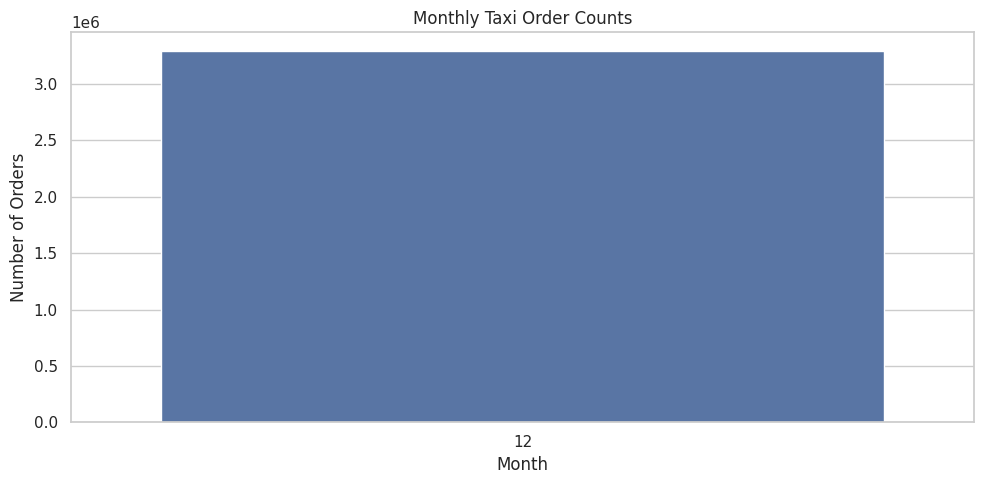

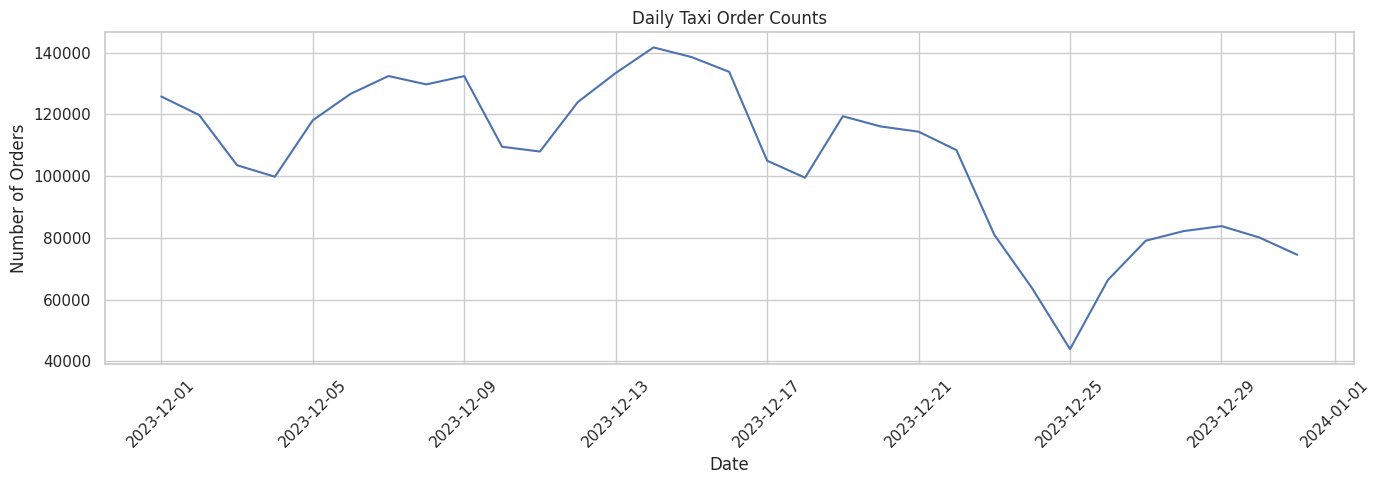

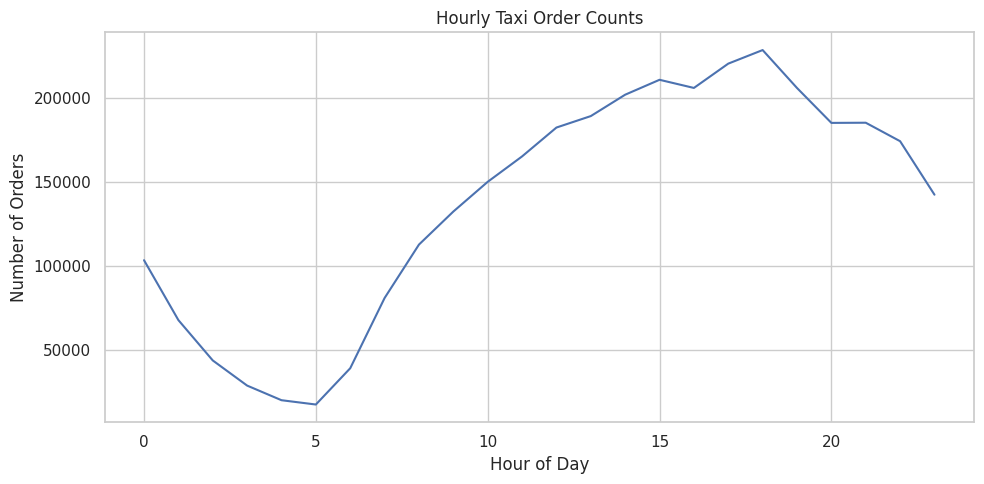

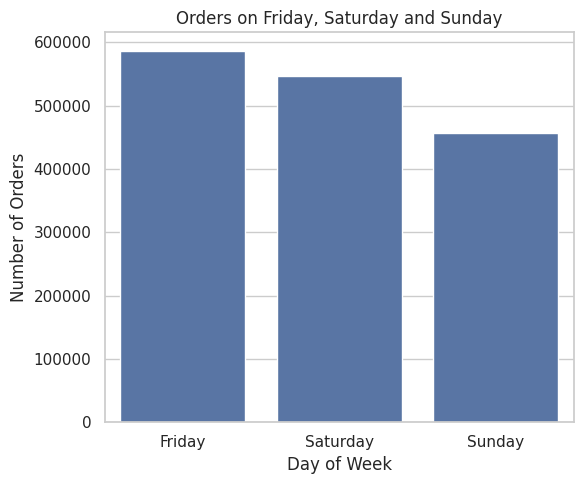

In [2]:
import pandas as pd
import seaborn as sns
from os import path
import glob
import matplotlib.pyplot as plt

# —— 1. 加载数据 ——
# 如果是 parquet：
df = pd.read_parquet('/content/drive/MyDrive/NYC_yellow_taxi/processed_output/yellow_tripdata_2023-01_2023-12_new.parquet', engine='pyarrow')
# 或者如果已经在内存里，则跳过此步

# —— 2. 确保时间列为 datetime ——
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# —— 3. 提取时间特征 ——
df['month']        = df['tpep_pickup_datetime'].dt.month
df['date']         = df['tpep_pickup_datetime'].dt.date
df['hour']         = df['tpep_pickup_datetime'].dt.hour
df['day_of_week']  = df['tpep_pickup_datetime'].dt.day_name()

# —— 4. 按月/日/时 统计订单数 ——
monthly_counts = (
    df.groupby('month')
      .size()
      .reset_index(name='order_count')
)

daily_counts = (
    df.groupby('date')
      .size()
      .reset_index(name='order_count')
)

hourly_counts = (
    df.groupby('hour')
      .size()
      .reset_index(name='order_count')
)

# —— 5. 周五/周六/周日 订单数 ——
weekend_days = ['Friday', 'Saturday', 'Sunday']
weekend_counts = (
    df[df['day_of_week'].isin(weekend_days)]
      .groupby('day_of_week')
      .size()
      .reindex(weekend_days)    # 保证顺序：Fri→Sat→Sun
      .reset_index(name='order_count')
)

# —— 6. 可视化 ——
sns.set(style="whitegrid")

# 月度订单柱状图
plt.figure(figsize=(10, 5))
sns.barplot(x='month', y='order_count', data=monthly_counts)
plt.title('Monthly Taxi Order Counts')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# 日度订单折线图
plt.figure(figsize=(14, 5))
sns.lineplot(x='date', y='order_count', data=daily_counts)
plt.title('Daily Taxi Order Counts')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 小时订单折线图
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='order_count', data=hourly_counts)
plt.title('Hourly Taxi Order Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# 周五/周六/周日订单柱状图
plt.figure(figsize=(6, 5))
sns.barplot(x='day_of_week', y='order_count', data=weekend_counts)
plt.title('Orders on Friday, Saturday and Sunday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


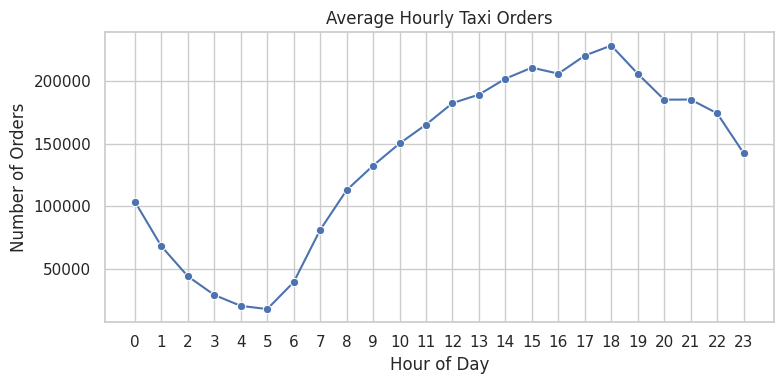

In [4]:
# 假设 df 已加载，且有 tpep_pickup_datetime 列
df['dt']   = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['dt'].dt.hour

# 每小时订单数
hourly = df.groupby('hour').size().reset_index(name='orders')

# 画每小时订单折线图
plt.figure(figsize=(8,4))
sns.lineplot(x='hour', y='orders', data=hourly, marker='o')
plt.title('Average Hourly Taxi Orders')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(range(0,24,1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df['dt']   = pd.to_datetime(df['tpep_pickup_datetime'])
df['date'] = df['dt'].dt.date
df['hour'] = df['dt'].dt.hour

hourly = (
  df
  .groupby(['date','hour'])
  .size()
  .reset_index(name='orders')
)


In [6]:
# 当日总量
daily_total = hourly.groupby('date')['orders'].sum().rename('daily_sum')
hourly = hourly.join(daily_total, on='date')

# 每小时占比
hourly['pct'] = hourly['orders'] / hourly['daily_sum']

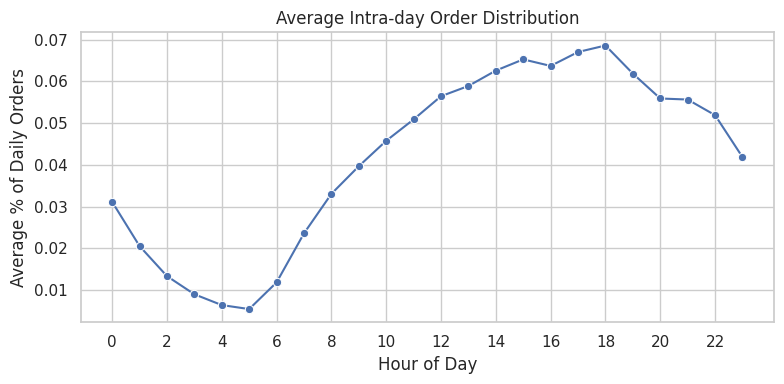

In [7]:
avg_profile = (
  hourly
  .groupby('hour')['pct']
  .mean()
  .reset_index()
)

plt.figure(figsize=(8,4))
sns.lineplot(x='hour', y='pct', data=avg_profile, marker='o')
plt.title('Average Intra-day Order Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Average % of Daily Orders')
plt.xticks(range(0,24,2))
plt.grid(True)
plt.tight_layout()
plt.show()


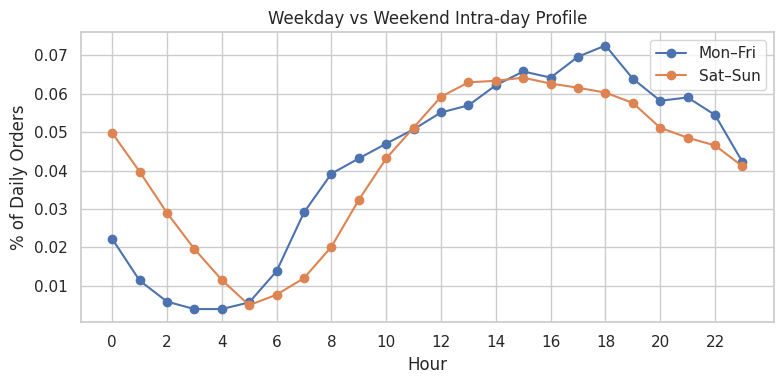

In [8]:
hourly['weekday']     = pd.to_datetime(hourly['date']).dt.day_name()
hourly['is_weekend']  = hourly['weekday'].isin(['Saturday','Sunday'])

prof_wd = (hourly[~hourly['is_weekend']]
           .groupby('hour')['pct']
           .mean()
           .rename('weekday_pct'))
prof_we = (hourly[ hourly['is_weekend']]
           .groupby('hour')['pct']
           .mean()
           .rename('weekend_pct'))

profile = pd.concat([prof_wd, prof_we], axis=1).reset_index()

plt.figure(figsize=(8,4))
plt.plot(profile['hour'], profile['weekday_pct'], label='Mon–Fri', marker='o')
plt.plot(profile['hour'], profile['weekend_pct'], label='Sat–Sun', marker='o')
plt.title('Weekday vs Weekend Intra-day Profile')
plt.xlabel('Hour')
plt.ylabel('% of Daily Orders')
plt.xticks(range(0,24,2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== Workday Morning (08:00–09:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,236,Upper East Side North,237,Upper East Side South,770
1,236,Upper East Side North,236,Upper East Side North,750
2,236,Upper East Side North,161,Midtown Center,742
3,237,Upper East Side South,236,Upper East Side North,710
4,237,Upper East Side South,161,Midtown Center,651
5,237,Upper East Side South,162,Midtown East,554
6,236,Upper East Side North,162,Midtown East,526
7,237,Upper East Side South,237,Upper East Side South,404
8,186,Penn Station/Madison Sq West,161,Midtown Center,388
9,186,Penn Station/Madison Sq West,234,Union Sq,375


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


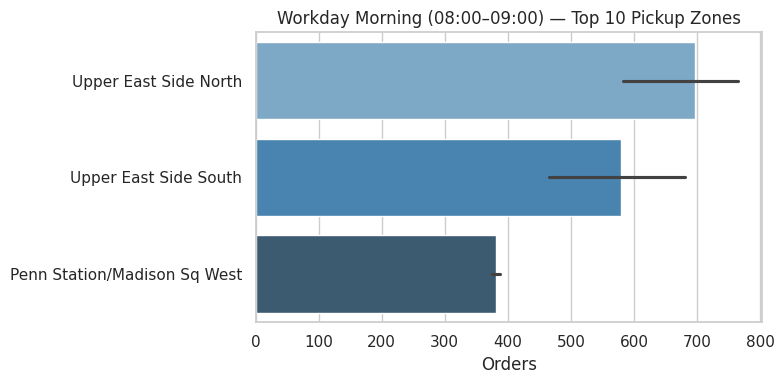

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


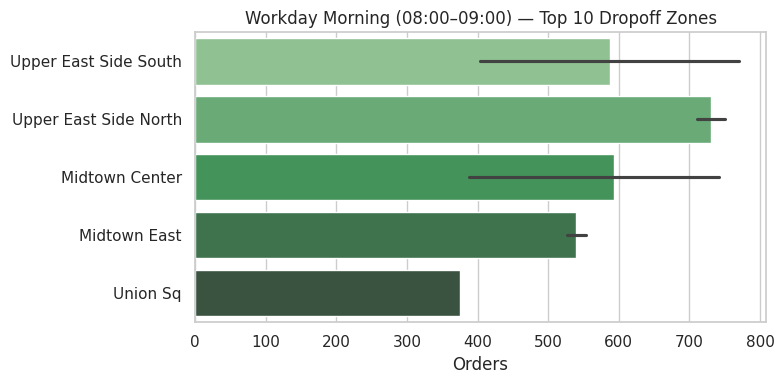

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


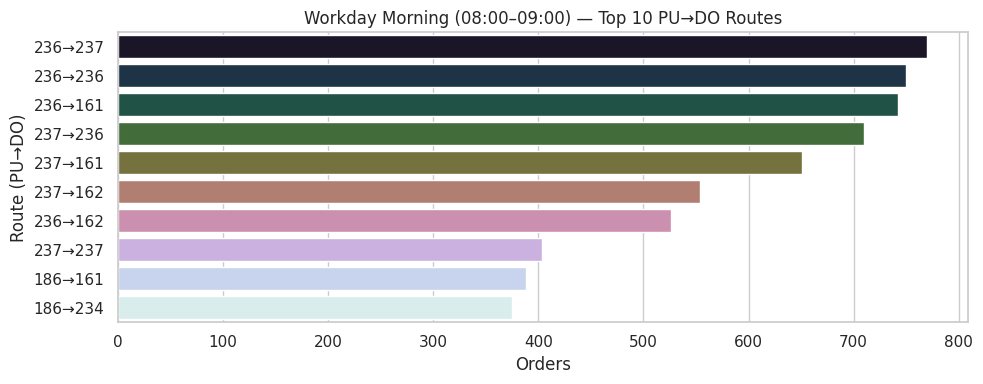


=== Workday Evening (17:00–18:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,237,Upper East Side South,236,Upper East Side North,1489
1,236,Upper East Side North,237,Upper East Side South,1310
2,236,Upper East Side North,236,Upper East Side North,1045
3,237,Upper East Side South,237,Upper East Side South,988
4,161,Midtown Center,237,Upper East Side South,621
5,142,Lincoln Square East,239,Upper West Side South,585
6,132,JFK Airport,230,Times Sq/Theatre District,571
7,239,Upper West Side South,238,Upper West Side North,562
8,162,Midtown East,237,Upper East Side South,544
9,239,Upper West Side South,142,Lincoln Square East,539


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


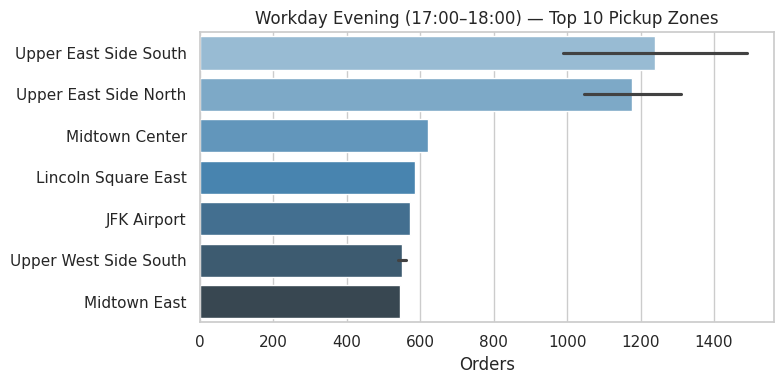

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


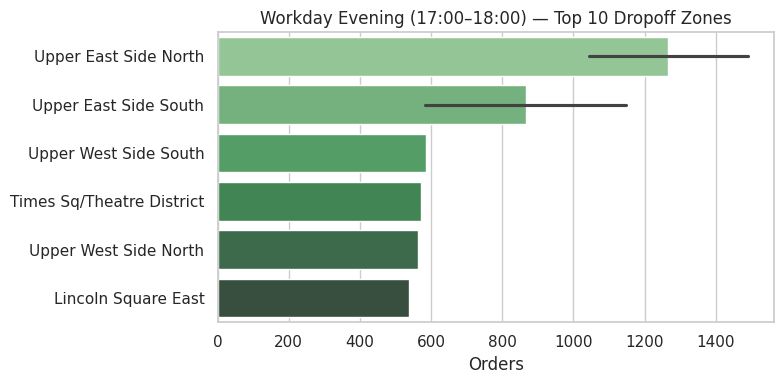

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


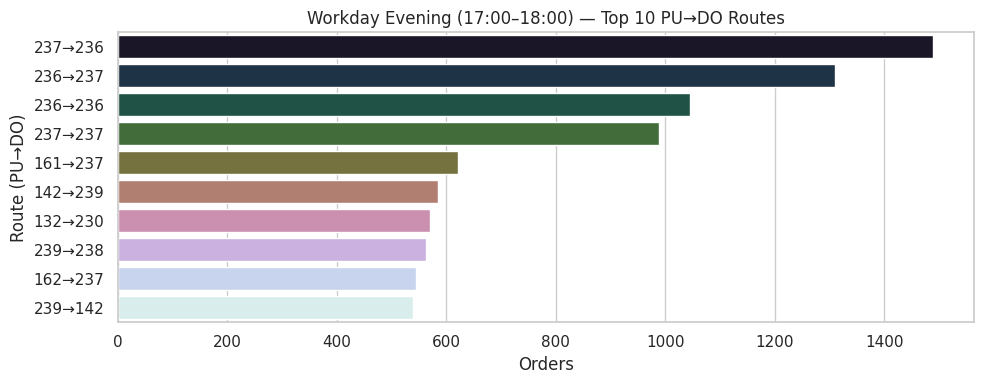


=== Workday Midnight (00:00–01:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,249,West Village,79,East Village,156
1,132,JFK Airport,132,JFK Airport,144
2,48,Clinton East,48,Clinton East,141
3,48,Clinton East,68,East Chelsea,133
4,114,Greenwich Village South,79,East Village,126
5,249,West Village,68,East Chelsea,123
6,230,Times Sq/Theatre District,186,Penn Station/Madison Sq West,115
7,79,East Village,107,Gramercy,113
8,249,West Village,249,West Village,112
9,249,West Village,231,TriBeCa/Civic Center,110


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


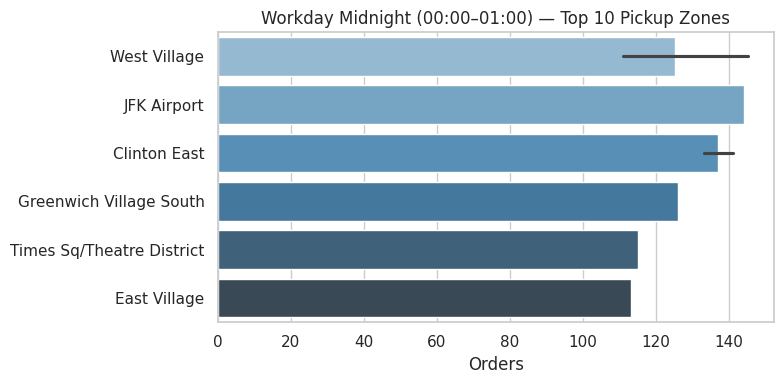

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


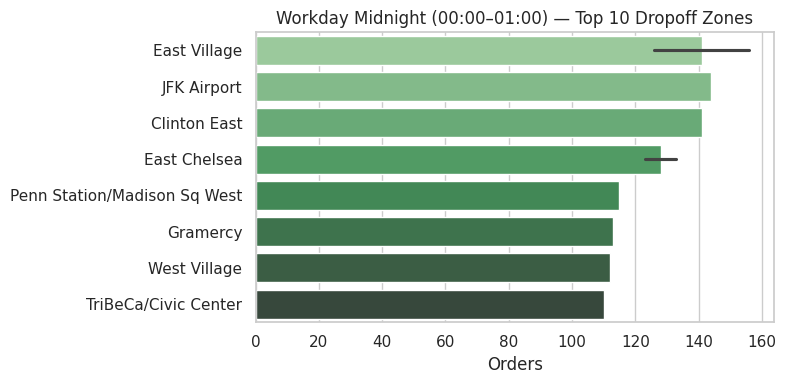

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


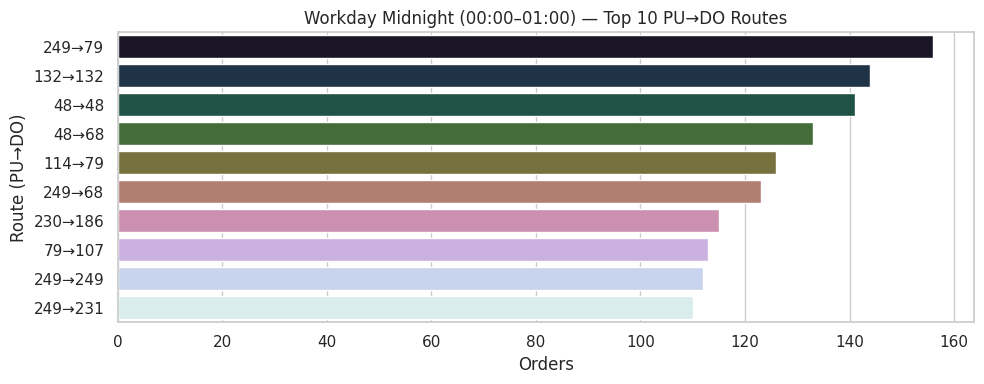


=== Weekend Morning (11:00–12:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,236,Upper East Side North,237,Upper East Side South,404
1,237,Upper East Side South,236,Upper East Side North,352
2,236,Upper East Side North,236,Upper East Side North,299
3,237,Upper East Side South,237,Upper East Side South,266
4,239,Upper West Side South,142,Lincoln Square East,247
5,186,Penn Station/Madison Sq West,230,Times Sq/Theatre District,239
6,237,Upper East Side South,161,Midtown Center,194
7,239,Upper West Side South,238,Upper West Side North,188
8,142,Lincoln Square East,239,Upper West Side South,182
9,238,Upper West Side North,239,Upper West Side South,179


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


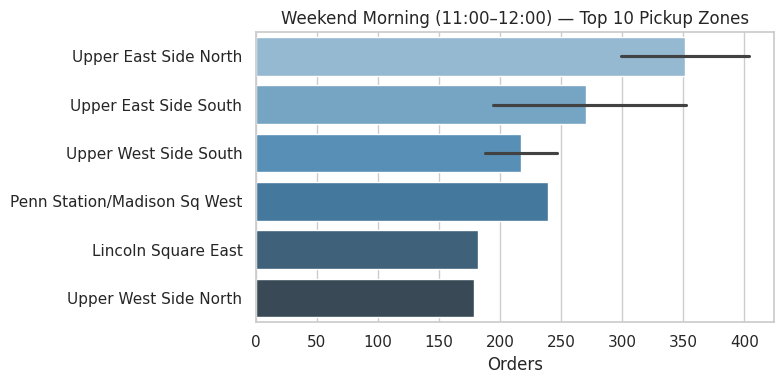

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


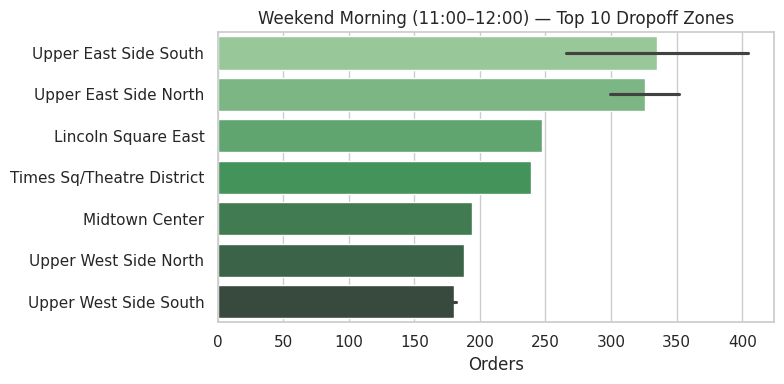

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


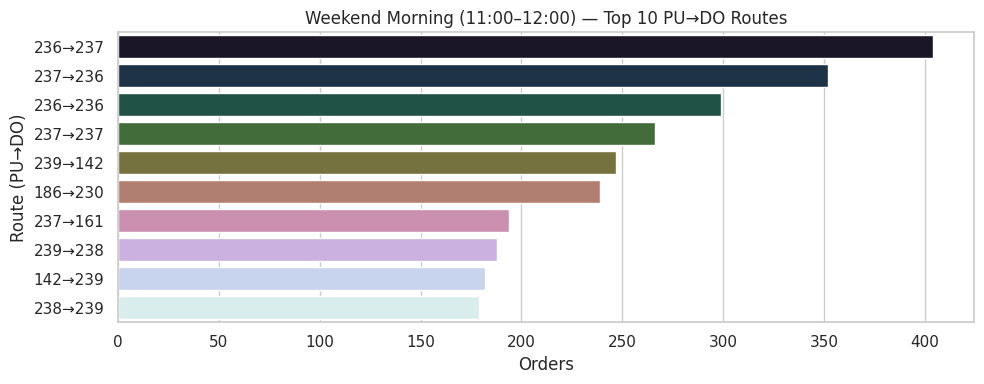


=== Weekend Evening (18:00–19:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,237,Upper East Side South,236,Upper East Side North,458
1,236,Upper East Side North,237,Upper East Side South,441
2,236,Upper East Side North,236,Upper East Side North,364
3,237,Upper East Side South,237,Upper East Side South,321
4,142,Lincoln Square East,239,Upper West Side South,289
5,239,Upper West Side South,142,Lincoln Square East,228
6,142,Lincoln Square East,238,Upper West Side North,205
7,142,Lincoln Square East,236,Upper East Side North,187
8,238,Upper West Side North,239,Upper West Side South,185
9,239,Upper West Side South,238,Upper West Side North,182


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


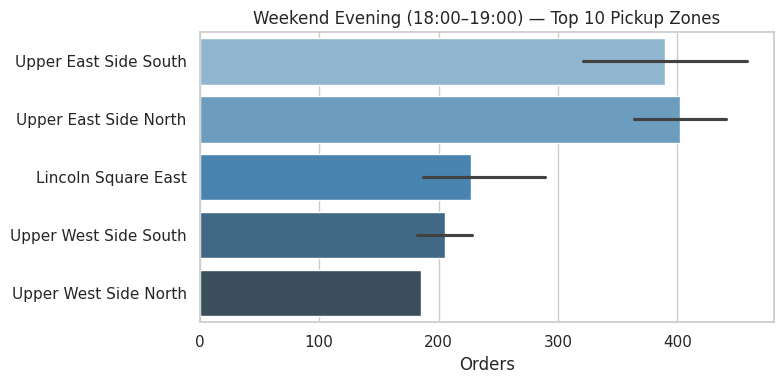

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


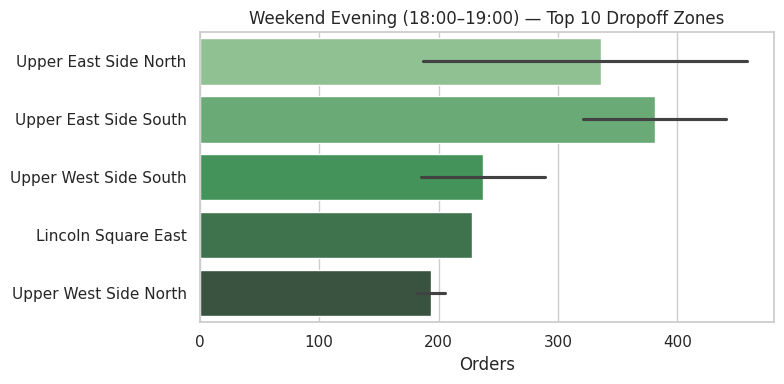

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


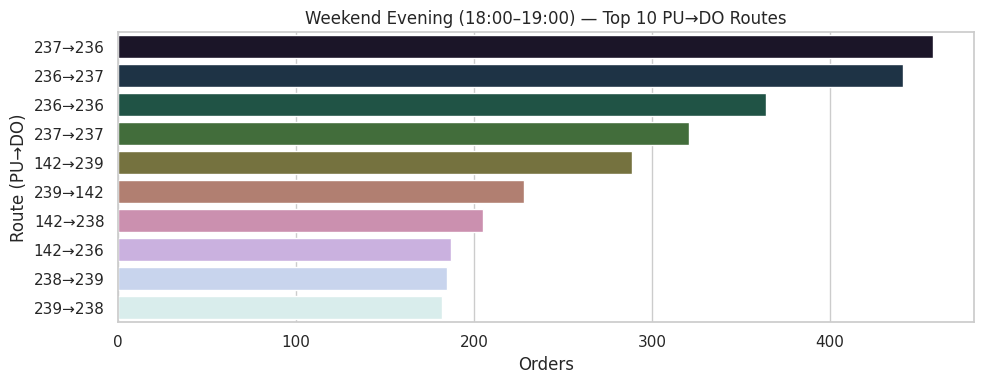


=== Weekend Midnight (00:00–02:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,249,West Village,79,East Village,521
1,79,East Village,170,Murray Hill,497
2,79,East Village,107,Gramercy,475
3,79,East Village,79,East Village,469
4,148,Lower East Side,79,East Village,464
5,79,East Village,249,West Village,392
6,79,East Village,148,Lower East Side,372
7,79,East Village,137,Kips Bay,348
8,114,Greenwich Village South,79,East Village,334
9,249,West Village,107,Gramercy,307


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


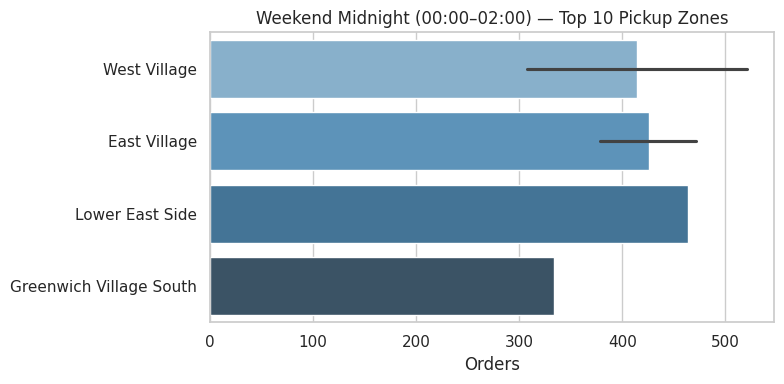

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


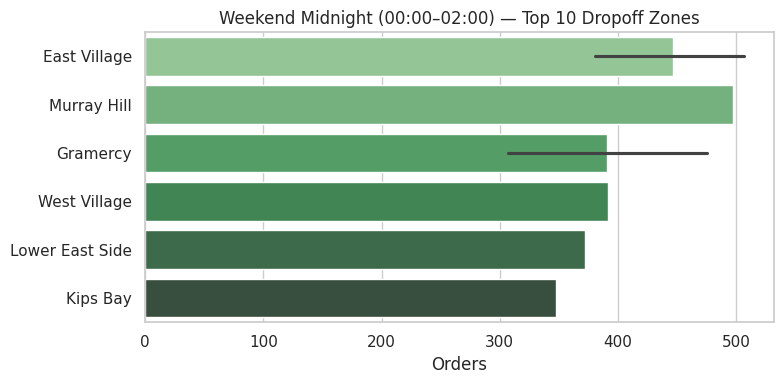

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


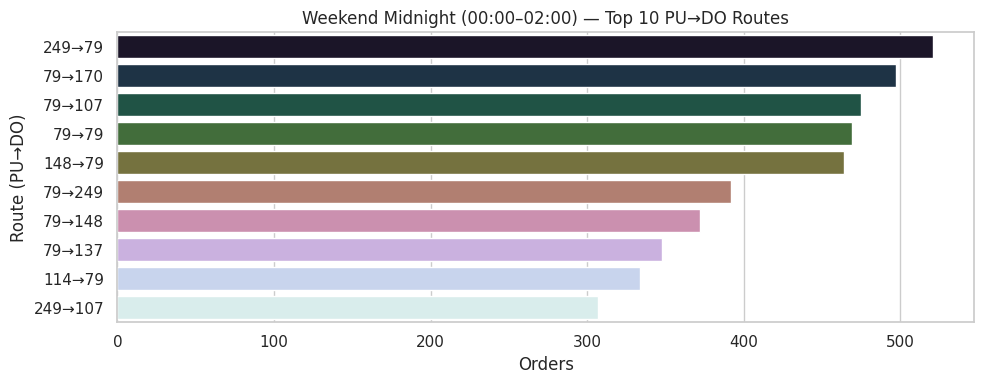


=== Midnight (03:00–06:00) Top 10 Routes ===


,PULocationID,PU Zone,DOLocationID,DO Zone,count
0,230,Times Sq/Theatre District,138,LaGuardia Airport,440
1,246,West Chelsea/Hudson Yards,48,Clinton East,353
2,79,East Village,79,East Village,324
3,230,Times Sq/Theatre District,132,JFK Airport,313
4,161,Midtown Center,138,LaGuardia Airport,300
5,48,Clinton East,68,East Chelsea,270
6,100,Garment District,161,Midtown Center,265
7,148,Lower East Side,79,East Village,260
8,48,Clinton East,48,Clinton East,248
9,132,JFK Airport,132,JFK Airport,245


<ipython-input-9-1571124743>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


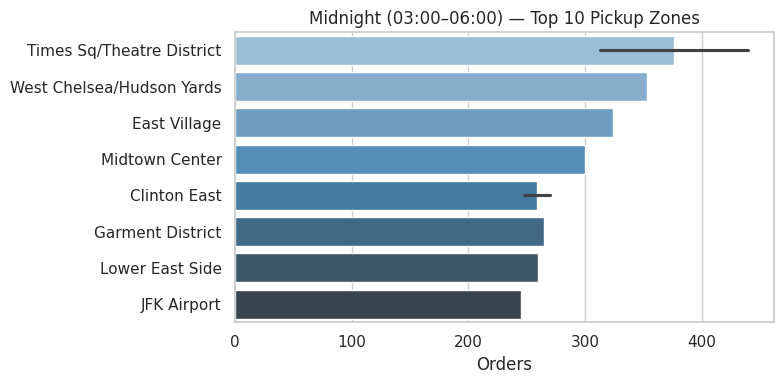

<ipython-input-9-1571124743>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


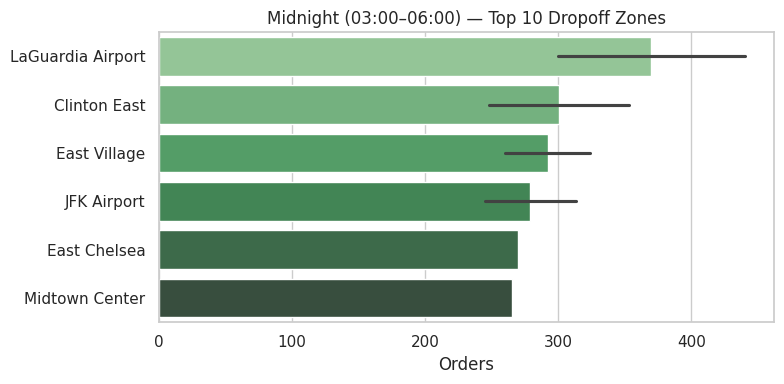

<ipython-input-9-1571124743>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


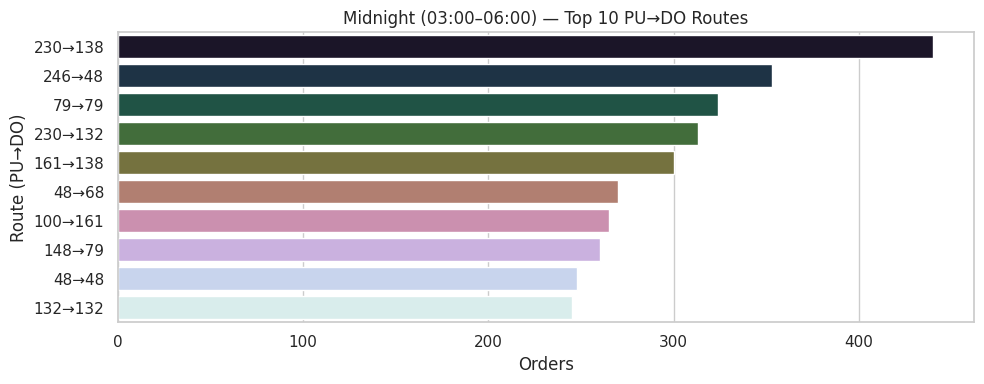

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# —— 1. 载入数据 ——
df    = pd.read_parquet(
    '/content/drive/MyDrive/NYC_yellow_taxi/processed_output/yellow_tripdata_2023-01_2023-12_new.parquet',
    engine='pyarrow'
)
zones = pd.read_csv('/content/drive/MyDrive/NYC_yellow_taxi/taxi_zone_with_coords.csv')  # 包含 LocationID, Zone

# —— 2. 增加辅助字段 ——
df['dt']   = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['dt'].dt.hour
df['day']  = df['dt'].dt.day_name()

# —— 3. 定义时段 ——
periods = {
    'Workday Morning (08:00–09:00)':   {'days': ['Monday','Tuesday','Wednesday','Thursday','Friday'], 'hours': [8]},
    'Workday Evening (17:00–18:00)':   {'days': ['Monday','Tuesday','Wednesday','Thursday','Friday'], 'hours': [17]},
    'Workday Midnight (00:00–01:00)':  {'days': ['Monday','Tuesday','Wednesday','Thursday','Friday'], 'hours': [0]},
    'Weekend Morning (11:00–12:00)':   {'days': ['Saturday','Sunday'], 'hours': [11]},
    'Weekend Evening (18:00–19:00)':   {'days': ['Saturday','Sunday'], 'hours': [18]},
    'Weekend Midnight (00:00–02:00)':  {'days': ['Saturday','Sunday'], 'hours': [0,1]},
    'Midnight (03:00–06:00)': {'days': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], 'hours': [3,4,5]}
}

# 全局 Seaborn 设置
sns.set(style="whitegrid")

for name, cfg in periods.items():
    # —— 4. 筛选该时段数据 ——
    mask = df['day'].isin(cfg['days']) & df['hour'].isin(cfg['hours'])
    sub  = df[mask]

    # —— 5. 统计 Top10 PU→DO 组合 ——
    top10 = (
        sub
        .groupby(['PULocationID','DOLocationID'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .head(10)
    )
    # 映射 Zone 名称
    top10 = (
        top10
        .merge(zones[['LocationID','Zone']], left_on='PULocationID', right_on='LocationID', how='left')
        .rename(columns={'Zone':'PU Zone'}).drop(columns='LocationID')
        .merge(zones[['LocationID','Zone']], left_on='DOLocationID', right_on='LocationID', how='left')
        .rename(columns={'Zone':'DO Zone'}).drop(columns='LocationID')
    )

    # —— 6. 输出表格 ——
    print(f"\n=== {name} Top 10 Routes ===")
    display(top10[['PULocationID','PU Zone','DOLocationID','DO Zone','count']])

    # —— 7. 可视化 ——

    # 7.1 Pickup Zone 柱状图
    plt.figure(figsize=(8,4))
    sns.barplot(
        data=top10,
        y='PU Zone',
        x='count',
        palette='Blues_d'
    )
    plt.title(f'{name} — Top 10 Pickup Zones')
    plt.xlabel('Orders')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # 7.2 Dropoff Zone 柱状图
    plt.figure(figsize=(8,4))
    sns.barplot(
        data=top10,
        y='DO Zone',
        x='count',
        palette='Greens_d'
    )
    plt.title(f'{name} — Top 10 Dropoff Zones')
    plt.xlabel('Orders')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # 7.3 Route 组合柱状图
    top10['route'] = top10['PULocationID'].astype(str) + '→' + top10['DOLocationID'].astype(str)
    plt.figure(figsize=(10,4))
    sns.barplot(
        data=top10,
        x='count',
        y='route',
        palette='cubehelix'
    )
    plt.title(f'{name} — Top 10 PU→DO Routes')
    plt.xlabel('Orders')
    plt.ylabel('Route (PU→DO)')
    plt.tight_layout()
    plt.show()
